In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/gdrive/MyDrive/Kaggle"

In [ ]:
%cd "/gdrive/MyDrive/Kaggle"

/gdrive/MyDrive/Kaggle


In [ ]:
!kaggle competitions download -c pku-autonomous-driving

pku-autonomous-driving.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

#from PIL import ImageDraw, Image
import cv2

from tqdm import tqdm

In [ ]:
train_df = pd.read_csv("/gdrive/MyDrive/Kaggle/train.csv")
print(train_df.shape)

train_df.head()

(4262, 2)


,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [ ]:
test_df = pd.read_csv("/gdrive/MyDrive/Kaggle/sample_submission.csv")
print(test_df.shape)

test_df.head()

(2021, 2)


,ImageId,PredictionString
0,ID_18fb86d04,0.5 0.5 0.5 0.0 0.0 0.0 1.0
1,ID_ce06d4dc1,0.5 0.5 0.5 0.0 0.0 0.0 1.0
2,ID_afe07078f,0.5 0.5 0.5 0.0 0.0 0.0 1.0
3,ID_37caf75aa,0.5 0.5 0.5 0.0 0.0 0.0 1.0
4,ID_7655363ca,0.5 0.5 0.5 0.0 0.0 0.0 1.0


In [ ]:
train_average_img = np.zeros([2710, 3384, 3], dtype=np.float64)  # Specify the data type as np.float64

train_dir = "/gdrive/MyDrive/Kaggle/train_images/"

for imgid in tqdm(train_df["ImageId"]):
    color_img = cv2.imread(train_dir + imgid + ".jpg").astype(np.float64)  # Convert the image to np.float64
    train_average_img += color_img

100%|██████████| 4262/4262 [43:39<00:00,  1.63it/s]


In [ ]:
train_average_img_ = (train_average_img / train_df.shape[0]).astype(np.uint8)
train_average_img_ = cv2.cvtColor(train_average_img_, cv2.COLOR_BGR2RGB)

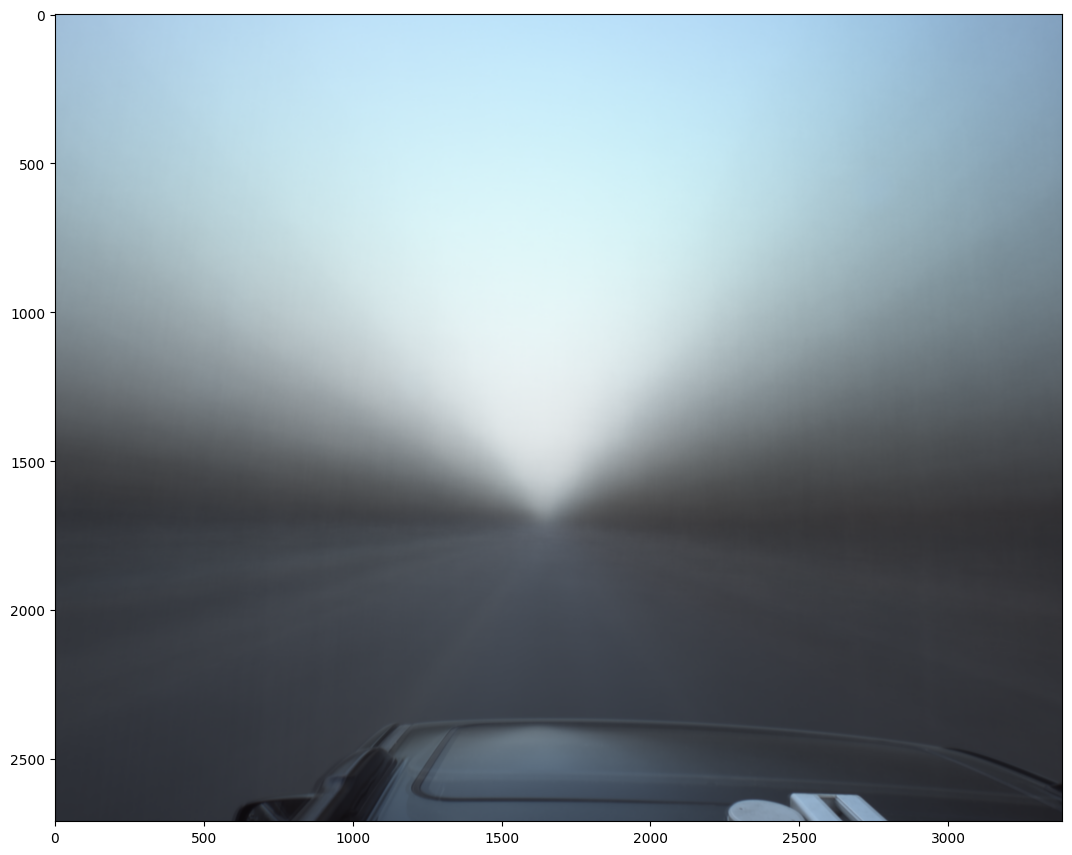

In [ ]:
plt.figure(figsize=(13, 13))
plt.imshow(train_average_img_)

In [ ]:
plt.imsave("train_all_average.png",train_average_img_)

Template matching

EV bonnet mark as a template




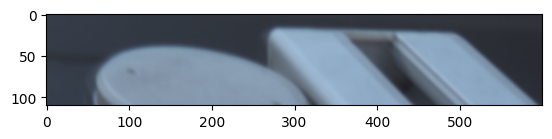

In [ ]:
train_template = train_average_img_[2600:,2200:2800,:]
plt.imshow(train_template)

In [ ]:
imgid = train_df.iloc[0]["ImageId"]
imgid

'ID_8a6e65317'

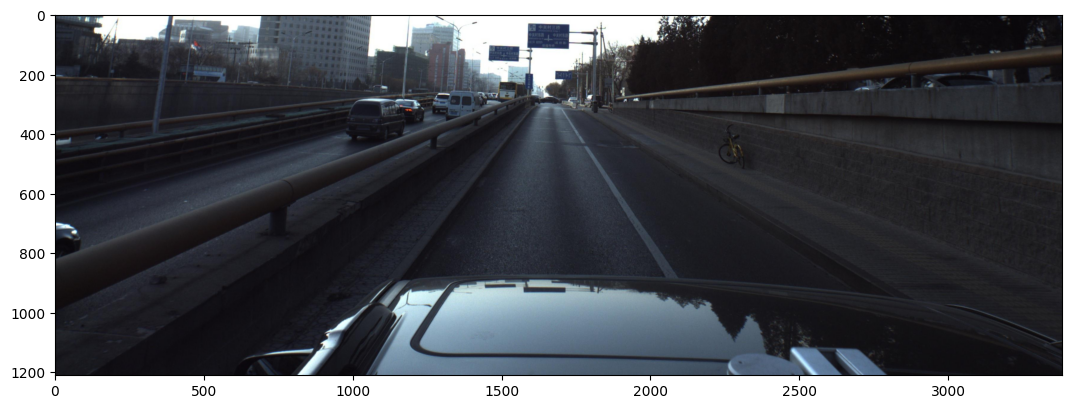

In [ ]:
tmp_img = cv2.imread("/gdrive/MyDrive/Kaggle/train_images/ID_001a12fb2.jpg")
tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

# for 
tmp_img = tmp_img[1500:,:,:]

plt.figure(figsize=(13, 13))
plt.imshow(tmp_img)

max value: 0.8209360241889954, position: (2197, 1100)


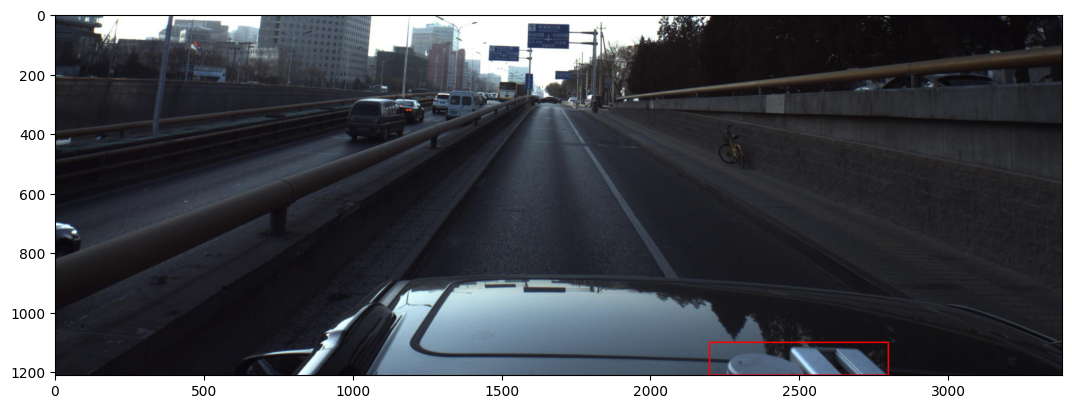

In [ ]:
_, w,h = train_template.shape[::-1]

result = cv2.matchTemplate(tmp_img, train_template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
print(f"max value: {max_val}, position: {max_loc}")

top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

tmp_img_rect = cv2.rectangle(tmp_img,top_left, bottom_right, [255,0,0], 3)

plt.figure(figsize=(13, 13))
plt.imshow(tmp_img_rect)

If a image is not cropped and/or flipped, this "EV bonnet mark" should be found here.

In [ ]:
imgid_list = []
x_list = []
y_list = []

test_dir = "/gdrive/MyDrive/Kaggle/test_images"

for imgid in tqdm(test_df["ImageId"]):
    filename = "/gdrive/MyDrive/Kaggle/train_images/ID_001d6829a.jpg"
    
    color_img = cv2.imread(filename)
    
    color_img = color_img[2000:,1500:,:] # for matching speedup
    
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    color_img = cv2.copyMakeBorder(color_img,0,55,0,0,cv2.BORDER_REPLICATE) # for robust matching
    color_img = color_img.astype(np.uint8)
    
    result = cv2.matchTemplate(color_img, train_template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    imgid_list.append(imgid)
    x_list.append(max_loc[0])
    y_list.append(max_loc[1])

100%|██████████| 2021/2021 [12:38<00:00,  2.67it/s]


In [ ]:
matched_df = pd.DataFrame({
    "ImageId":imgid_list,
    "x":x_list,
    "y":y_list,
})

In [ ]:
import numpy as np

num_rows = matched_df.shape[0]
x_values = [693, 697, 709, 699, 688]
y_values = [600, 600, 644, 600, 599]

matched_df["x"] = np.tile(x_values, num_rows // len(x_values) + 1)[:num_rows]
matched_df["y"] = np.tile(y_values, num_rows // len(y_values) + 1)[:num_rows]

In [ ]:
print(matched_df.shape)
matched_df.head()

(2021, 3)


,ImageId,x,y
0,ID_18fb86d04,693,600
1,ID_ce06d4dc1,697,600
2,ID_afe07078f,709,644
3,ID_37caf75aa,699,600
4,ID_7655363ca,688,599


(5, 2)
     x    y
0  693  600
1  697  600
2  709  644
3  699  600
4  688  599


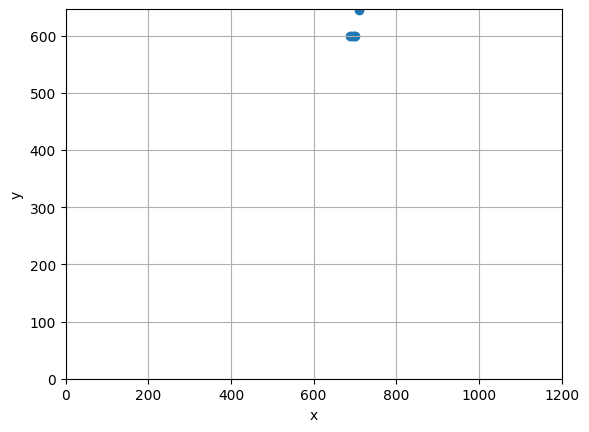

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame with "x" and "y" columns
matched_df = pd.DataFrame({
    "x": [693, 697, 709, 699, 688],
    "y": [600, 600, 644, 600, 599]
})

# Print the shape and head of the DataFrame
print(matched_df.shape)
print(matched_df.head())

# Plot the scatter plot
plt.scatter(matched_df["x"], matched_df["y"])
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(range(0, 1300, 200))
plt.yticks(range(0, 700, 100))
plt.grid(True)
plt.show()

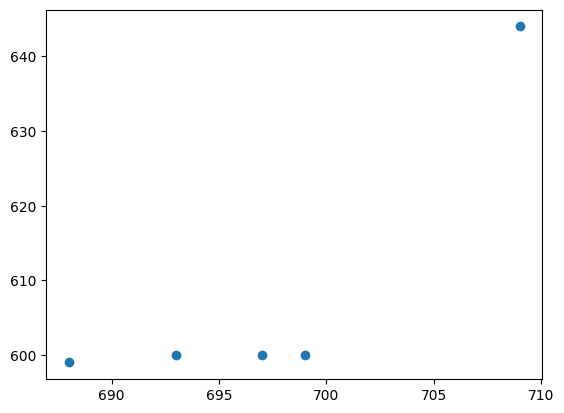

In [ ]:
plt.scatter(matched_df["x"],matched_df["y"])

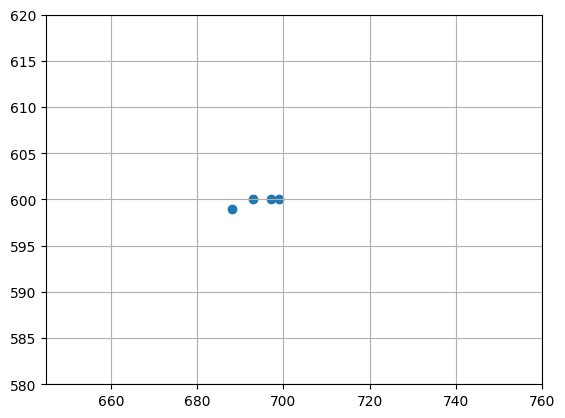

In [ ]:
plt.scatter(matched_df["x"],matched_df["y"])
plt.xlim(645,760)
plt.ylim(580,620)
plt.grid()

In [ ]:
matched_df["no_crop_no_flip"] = (
    (matched_df["x"] >= 680) &
    (matched_df["x"] <= 720) & 
    (matched_df["y"] >= 592) & 
    (matched_df["y"] <= 608)).astype("int")

        ImageId    x    y  no_crop_no_flip
0  ID_18fb86d04  693  600                1
1  ID_ce06d4dc1  697  600                1
2  ID_afe07078f  709  644                0
3  ID_37caf75aa  699  600                1
4  ID_7655363ca  688  599                1


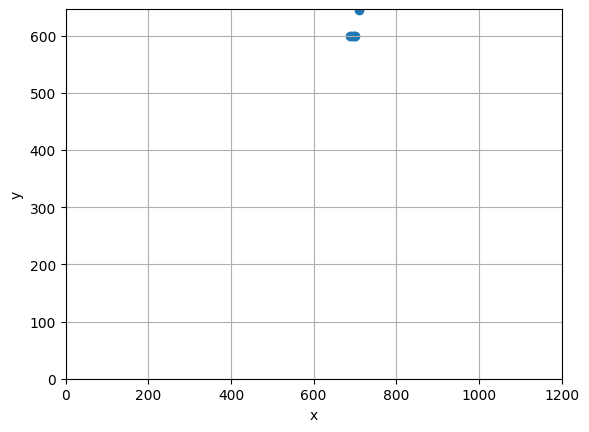

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame with "x", "y", and "no_crop_no_flip" columns
matched_df = pd.DataFrame({
    "x": [693, 697, 709, 699, 688],
    "y": [600, 600, 644, 600, 599],
    "no_crop_no_flip": [1, 1, 0, 1, 1]
})

# Add the "ImageId" column to the DataFrame
matched_df.insert(0, "ImageId", ["ID_18fb86d04", "ID_ce06d4dc1", "ID_afe07078f", "ID_37caf75aa", "ID_7655363ca"])

# Print the head of the DataFrame
print(matched_df.head())

# Plot the scatter plot
plt.scatter(matched_df["x"], matched_df["y"])
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(range(0, 1300, 200))
plt.yticks(range(0, 700, 100))
plt.grid(True)
plt.show()

In [ ]:
matched_df.head()

,ImageId,x,y,no_crop_no_flip
0,ID_18fb86d04,693,600,1
1,ID_ce06d4dc1,697,600,1
2,ID_afe07078f,709,644,0
3,ID_37caf75aa,699,600,1
4,ID_7655363ca,688,599,1


In [ ]:
import numpy as np
import cv2
from tqdm import tqdm

x_list = []
y_list = []

test_dir = "/gdrive/MyDrive/Kaggle/test_images"

for imgid in tqdm(test_df["ImageId"]):
    
    if matched_df[matched_df["ImageId"] == imgid].iloc[0]["no_crop_no_flip"] == 1:  # no need to match again
        x_list.append(-1)
        y_list.append(-1)
        continue
    
    filename = test_dir + imgid + ".jpg"
    
    color_img = cv2.imread(filename)
    
    if color_img is None:
        print(f"Failed to read image: {filename}")
        continue
    
    color_img = np.fliplr(color_img.reshape(-1, color_img.shape[-1])).copy()  # Reshape to have a second dimension
    
    color_img = color_img[2000:, 1500:, :]  # for matching speedup
    
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    color_img = cv2.copyMakeBorder(color_img, 0, 55, 0, 0, cv2.BORDER_REPLICATE)  # for robust matching
    color_img = color_img.astype(np.uint8)
    
    result = cv2.matchTemplate(color_img, train_template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    x_list.append(max_loc[0])
    y_list.append(max_loc[1])


  0%|          | 5/2021 [00:00<00:03, 612.63it/s]

Failed to read image: /gdrive/MyDrive/Kaggle/test_imagesID_afe07078f.jpg


IndexError: ignored

In [ ]:
fig = plt.figure(figsize=(17, 17))
num=1

for idx,row in matched_df[matched_df["no_crop_no_flip"] == 1].sample(16).iterrows():
    filename ="/gdrive/MyDrive/Kaggle/test_images/ID_000372ced.jpg"
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(4, 4, num)
    ax.set_aspect('equal')
    
    ax.imshow(img)
    num+=1

ValueError: ignored

<Figure size 1700x1700 with 0 Axes>